In [2]:
import numpy as np
import cv2 
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

In [3]:
def detectAndDescribe( image):
        # check to see if we are using OpenCV 3.X
        # detect and extract features from the image
        
        descriptor = cv2.xfeatures2d.SIFT_create()
        #descriptor = cv2.xfeatures2d.SURF_create()
        #descriptor = cv2.ORB_create(nfeatures=1500)
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

In [4]:
def matchKeypoints( kpsA, kpsB, featuresA, featuresB,
ratio, reprojThresh):
# compute the raw matches and initialize the list of actual
# matches
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    # loop over the raw matches
    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)

    # otherwise, no homograpy could be computed
    return None

def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # return the visualization
    return vis

In [5]:

imageA = cv2.imread('images/covid-chestxray-dataset/images/wong-0004.jpg', cv.IMREAD_GRAYSCALE)  # referenceImage
imageB = cv2.imread('images/covid-chestxray-dataset/images/wong-0002.jpg', cv.IMREAD_GRAYSCALE)  # sensedImage




In [6]:
imageA = cv2.resize(imageA, (299, 299), interpolation = cv2.INTER_AREA)
imageB = cv2.resize(imageB, (299, 299), interpolation = cv2.INTER_AREA)

imageA = cv2.equalizeHist(imageA)
imageB = cv2.equalizeHist(imageB)

In [7]:
# import the necessary packages
import numpy as np
import cv2


ratio= 0.8
reprojThresh=0
# unpack the images, then detect keypoints and extract
# local invariant descriptors from them
(kpsA, featuresA) =   detectAndDescribe(imageA)
(kpsB, featuresB) =   detectAndDescribe(imageB)

# match features between the two images
M = matchKeypoints( kpsA,   kpsB,
    featuresA, featuresB,  ratio,  reprojThresh)
 

In [8]:
# otherwise, apply a perspective warp to stitch the images
# together
showMatches = True
(matches, H, status) = M
result = cv2.warpPerspective(imageA, H,
    (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
#result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

# check to see if the keypoint matches should be visualized
if showMatches:
    vis = drawMatches(imageA, imageB, kpsA, kpsB, matches,
        status)



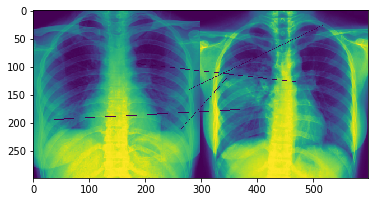

In [9]:
 plt.imshow(vis)

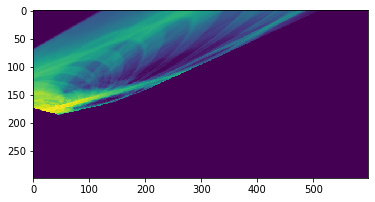

In [10]:
 plt.imshow(result)

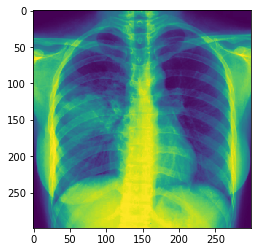

In [11]:
 plt.imshow(imageB)